# Similar Product Recommendations
> A tutorial on building a recommender system that will find similar looking products

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F09280297-5ac3-402d-8e04-7b6a8a182c97%2FUntitled.png?table=block&id=ef21d77b-7db0-4b82-a818-214716bbd8b4&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

## Choice of variables

- Image Encoder: Any pre-trained image classification model can be selected. These models are commonly known as encoders because their job is to encode an image into a feature vector. In our case, we analyzed four encoders named 1) MobileNet, 2) EfficientNet, 3) ResNet and 4) [BiT](https://tfhub.dev/google/bit/m-r152x4/1). After some basic research, we decided to select BiT model because of its performance. I selected the BiT-M-50x3 variant of model which is of size 748 MB. More details about this architecture can be found on the official page [here](https://tfhub.dev/google/bit/m-r50x3/1).
- Vector Similarity System: Images are represented in a fixed-length feature vector format. For the given input vector, we need to find the TopK most similar vectors, keeping the memory efficiency and real-time retrival objective in mind. We explored the most popular techniques and listed down five of them: Annoy, Cosine distance, L1 distance, Locally Sensitive Hashing (LSH) and Image Deep Ranking. We selected Annoy because of its fast and efficient nature. More details about Annoy can be found on the official page [here](https://github.com/spotify/annoy).
- Dataset: This system is able to handle all kind of image dataset. Only the basic preprocessing (in step 1) would need some modifications depending on the dataset. We chose [Fashion Product Images (Small)](https://www.kaggle.com/bhaskar2443053/fashion-small?). Other examples can be [Food-11 image dataset](https://www.kaggle.com/trolukovich/food11-image-dataset?), and [Caltech 256 Image Dataset](https://www.kaggle.com/jessicali9530/caltech256?).

## Step 1: Data Acquisition

Download the raw image dataset into a directory. Categorize these images into their respective category directories. Make sure that images are of the same type, JPEG recommended. We will also process the metadata and store it in a serialized file, CSV recommended. 

In [ ]:
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

## Step 2: Encoder Fine-tuning [optional]

Download the pre-trained image model and add two additional layers on top of that: the first layer is a feature vector layer and the second layer is the classification layer. We will only train these 2 layers on our data and after training, we will select the feature vector layer as the output of our fine-tuned encoder. After fine-tuning the model, we will save the feature extractor for later use.

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.12.0
GPU is available


In [ ]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [ ]:
data_dir = '/content/Fashion_data/categories'

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 6144)              211174080 
_________________________________________________________________
dropout_2 (Dropout)          (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1573120   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________________________________


In [ ]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1221s 1s/step - loss: 0.4232 - accuracy: 0.9410 - val_loss: 0.1400 - val_accuracy: 0.9878
Epoch 2/5
1111/1111 [==============================] - 1210s 1s/step - loss: 0.2100 - accuracy: 0.9760 - val_loss: 0.1399 - val_accuracy: 0.9879
Epoch 3/5
1111/1111 [==============================] - 1210s 1s/step - loss: 0.2115 - accuracy: 0.9766 - val_loss: 0.1397 - val_accuracy: 0.9880
Epoch 4/5
1111/1111 [==============================] - 1210s 1s/step - loss: 0.2094 - accuracy: 0.9763 - val_loss: 0.1396 - val_accuracy: 0.9880
Epoch 5/5
1111/1111 [==============================] - 1210s 1s/step - loss: 0.1923 - accuracy: 0.9775 - val_loss: 0.1394 - val_accuracy: 0.9880


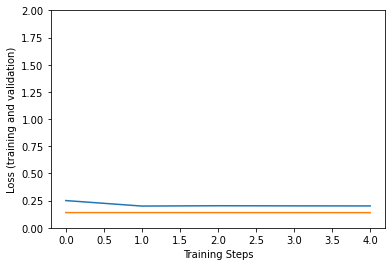

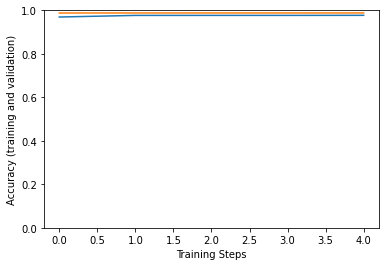

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_model/assets


## Step 3: Image Vectorization
Now, we will use the encoder (prepared in step 2) to encode the images (prepared in step 1). We will save feature vector of each image as an array in a directory. After processing, we will save these embeddings for later use.

In [ ]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [ ]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

## Step 4: Metadata and Indexing

We will assign a unique id to each image and create dictionaries to locate information of this image: 1) Image id to Image name dictionary, 2) Image id to image feature vector dictionary, and 3) (optional) Image id to metadata product id dictionary. We will also create an image id to image feature vector indexing. Then we will save these dictionaries and index object for later use.

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

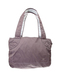

In [ ]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
styles = pd.read_csv('/content/styles.csv', error_bad_lines=False)
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles.csv', index=False)

In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors 
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  t.add_item(findex, file_vector)

5000it [00:17, 279.67it/s]


In [ ]:
t.build(trees)
t.save('t.ann')

True

In [ ]:
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Step 5: Local Testing

We will load a random image and find top-K most similar images.

In [ ]:
from PIL import Image
import matplotlib.image as mpimg

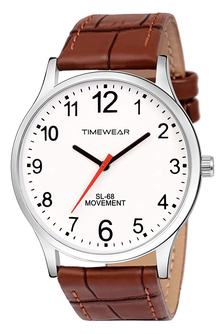

In [ ]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

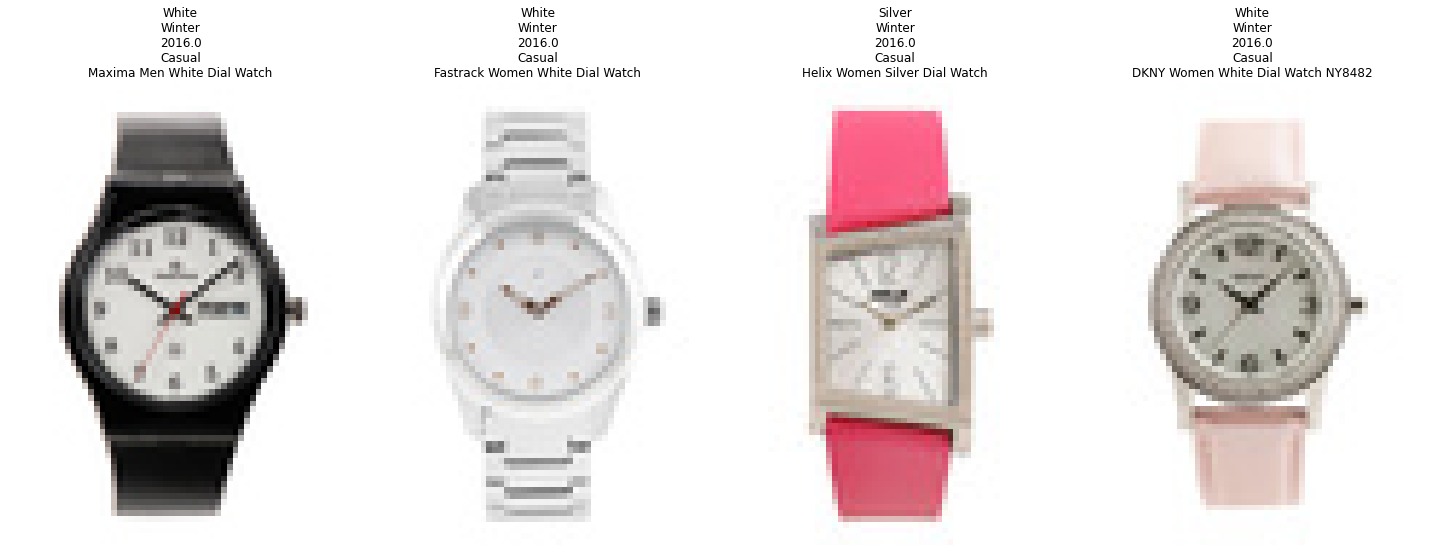

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

## Step 6: API Call

We will build two kinds of API - 1) UI based API using Streamlit, and 2) REST API using Flask. In both the cases, we will receive an image from user, encode it with our image encoder, find TopK similar vectors using Indexing object, and retrieve the image (and metadata) using dictionaries. We send these images (and metadata) back to the user.

In [ ]:
import os
import time

In [ ]:
root_path = '/content/drive/MyDrive/ImgSim'

In [ ]:
%%writefile utils.py
## ----utils.py---- ###

import os
import tensorflow as tf
from annoy import AnnoyIndex

root_path = '/content/drive/MyDrive/ImgSim'

class Encoder:
  encoder = tf.keras.models.load_model(os.path.join(root_path, 'bit_feature_extractor'))

class Indexer:
  dims = 256
  topK = 6
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(root_path, 'indexer.ann'))
  
encoder = Encoder()
indexer = Indexer()

Writing utils.py


## Streamlit App

In [ ]:
%%writefile app.py
## ----app.py---- ###

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer

root_path = '/content/drive/MyDrive/ImgSim'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# load the mappings
file_index_to_file_name = pickle.load(open(os.path.join(root_path ,'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path ,'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path ,'file_index_to_product_id.p'), 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

st.title("Image Similarity App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Top similar images...")
    
    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    start_time = time.time()
    for i in nns:
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)

Writing app.py


In [ ]:
! pip install -q pyngrok
! pip install -q streamlit
! pip install -q colab-everything

from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

## Flask API

### server-side

In [ ]:
%%writefile flask_app.py
## ----flask_app.py---- ###

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify, send_file

_PPATH = '/content/drive/MyDrive/ImgSim/'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(_PPATH+'styles.csv')

# load the mappings
file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

def get_encoded_img(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    my_encoded_img = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')
    return my_encoded_img


app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save(query_path)

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = {}
    img_captions = {}

    start_time = time.time()
    for count, i in enumerate(nns):
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files[count] = get_encoded_img(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions[count] = img_caption
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    return jsonify(img_files)

app.run(debug=True)

In [ ]:
!nohup python3 -u flask_app.py &

nohup: appending output to 'nohup.out'


### client-side

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import requests

!wget -O 'img.jpg' -q 'https://images-na.ssl-images-amazon.com/images/I/61utX8kBDlL._UL1100_.jpg'

url = 'http://localhost:5000/fashion'
my_img = {'image': open('img.jpg', 'rb')}
r = requests.post(url, files=my_img)

imgs = []
for i in range(6):
  img = base64.decodebytes(r.json()[str(i)].encode('ascii'))
  img = Image.open(BytesIO(img)).convert('RGBA')
  imgs.append(img)

imgs[1]

## Step 7: Deployment on AWS Elastic BeanStalk

The API was deployed on AWS cloud infrastructure using AWS Elastic Beanstalk service.

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F3305ebeb-315b-4d64-b0f7-315284f52790%2FUntitled.png?table=block&id=85c7129d-676e-4e50-9519-67a8dad0cbfa&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

## application.py

In [ ]:
%%writefile ./ebsapp/application.py
import os
import zipfile
import requests
from tqdm import tqdm
from shutil import move
from pandas import read_csv
from pathlib import Path
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import glob
import json
from tqdm import tqdm
from annoy import AnnoyIndex
from scipy import spatial
import pickle
import time
from PIL import Image
import tarfile
import io
import base64
from flask import Flask, request, jsonify, send_file
from flask import redirect, url_for, flash, render_template

# path = Path(__file__)
# _PPATH = str(path.parents[1])+'/'
_PPATH = os.path.join(os.getcwd(), 'mytemp')

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
module = hub.load(module_handle)

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

topK = 5
threshold = 0.3
UPLOAD_FOLDER = _PPATH
ALLOWED_EXTENSIONS = set(['zip'])

application = Flask(__name__)
           
@application.route('/')
def hello_world():
    return "Hello world!"

@application.route('/original_images', methods=['POST'])
def upload_zip1():
  os.makedirs(_PPATH, exist_ok=True)
  shutil.rmtree(_PPATH)
  os.makedirs(_PPATH, exist_ok=True)
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip1.zip'))

  zip1_path = os.path.join(_PPATH, 'zip1.zip')
  zip1_ipath = os.path.join(_PPATH, 'zip1')
  os.makedirs(zip1_ipath, exist_ok=True)
  with zipfile.ZipFile(zip1_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip1'))

  img_paths = []
  for path in Path(zip1_ipath).rglob('*.jpg'):
    img_paths.append(path)

  imgvec_path = os.path.join(_PPATH, 'vecs1')
  Path(imgvec_path).mkdir(parents=True, exist_ok=True)

  for filename in tqdm(img_paths):
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    if not os.path.exists(out_path_file):
      img = load_img(str(filename))
      features = module(img)
      feature_set = np.squeeze(features)
      print(features.shape)
      np.savetxt(out_path_file, feature_set, delimiter=',')

  # Defining data structures as empty dict
  file_index_to_file_name = {}
  file_index_to_file_vector = {}

  # Configuring annoy parameters
  dims = 2048
  n_nearest_neighbors = 20
  trees = 10000

  # Reads all file names which stores feature vectors 
  allfiles = glob.glob(os.path.join(_PPATH, 'vecs1', '*.npz'))

  t = AnnoyIndex(dims, metric='angular')

  for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)
    file_name = os.path.basename(fname).split('.')[0]
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector
    t.add_item(findex, file_vector)

  t.build(trees)

  file_path = os.path.join(_PPATH,'models/indices/')
  Path(file_path).mkdir(parents=True, exist_ok=True)

  t.save(file_path+'indexer.ann')
  pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
  pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))

  return 'File processed on the server status OK!'

@application.route('/test_images', methods=['POST'])
def upload_zip2():
  os.chdir(_PPATH)
  file = request.files['file']
  if file and allowed_file(file.filename):
      file.save(os.path.join(UPLOAD_FOLDER, 'zip2.zip'))

  zip2_path = os.path.join(_PPATH, 'zip2.zip')
  zip2_ipath = os.path.join(_PPATH, 'zip2')
  os.makedirs(zip2_ipath, exist_ok=True)
  with zipfile.ZipFile(zip2_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(_PPATH, 'zip2'))

  query_files = []
  for path in Path(zip2_ipath).rglob('*.jpg'):
    query_files.append(path)
  
  dims = 2048
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(_PPATH,'models/indices/indexer.ann'))
  file_index_to_file_name = pickle.load(open(os.path.join(_PPATH,'models/indices/file_index_to_file_name.p'), 'rb'))

  results = pd.DataFrame(columns=['qid','fname','dist'])

  for q in query_files:
    temp_vec = np.squeeze(module(load_img(str(q))))
    nns = indexer.get_nns_by_vector(temp_vec, n=topK, include_distances=True)
    col1 = [q.stem]*topK
    col2 = [file_index_to_file_name[x] for x in nns[0]]
    col3 = nns[1]
    results = results.append(pd.DataFrame({'qid':col1,'fname':col2,'dist':col3}))
    results = results[results.dist<=threshold]
  
  results = results.reset_index(drop=True).T.to_json()
  return results
  
 # run the app.
if __name__ == "__main__":
    # Setting debug to True enables debug output. This line should be
    # removed before deploying a production app.
    application.debug = True
    application.run()

## requirements.txt

In [ ]:
%%writefile ./ebsapp/requirements.txt
annoy==1.16.3
Pillow==2.2.2
click==7.1.2
Flask==1.1.2
itsdangerous==1.1.0
Jinja2==2.11.2
MarkupSafe==1.1.1
Werkzeug==1.0.1
numpy==1.18.5
pandas==1.0.5
pathlib==1.0.1
pip-tools==4.5.1
requests==2.23.0
scipy==1.4.1
tensorflow==2.0.0b1
tensorflow-hub==0.8.0
tqdm==4.41.1
urllib3==1.24.3
zipfile36==0.1.3

## packages.config

In [ ]:
%%writefile ./ebsapp/.ebextensions/01_packages.config
packages:
  yum:
    gcc-c++: []
    unixODBC-devel: []
files:
  "/etc/httpd/conf.d/wsgi_custom.conf":
    mode: "000644"
    owner: root
    group: root
    content: |
      WSGIApplicationGroup %{GLOBAL}

## extras
some handy EBS commands

In [ ]:
# !pip install aws.sam.cli
# !sam init

# %cd my-app

# !git config --global user.email "<email>"
# !git config --global user.name  "sparsh-ai"
# !git init
# !git status
# !git add .
# !git commit -m 'commit'

# !pip install awscli
# !aws configure

# !sam build && sam deploy
# !pip install flask-lambda-python36

# !aws ec2 create-key-pair --key-name MyKeyPair --query 'KeyMaterial' --output text > MyKeyPair.pem
# !chmod 400 MyKeyPair.pem
# !aws ec2 describe-instances --filters "Name=instance-type,Values=t2.micro" --query "Reservations[].Instances[].InstanceId"
# !ssh -i MyKeyPair.pem ec2-user@ec2-50-xx-xx-xxx.compute-1.amazonaws.com

# !git clone https://github.com/aws/aws-elastic-beanstalk-cli-setup.git
# build-essential zlib1g-dev libssl-dev libncurses-dev libffi-dev libsqlite3-dev libreadline-dev libbz2-dev

# !pip install awscli
# !pip install awsebcli
# !aws configure

# !mkdir eb-flask
# %cd eb-flask

# python --version
# pip install awsebcli --upgrade --user
# eb --version
# mkdir eb-flask
# cd eb-flask
# pip install virtualenv
# virtualenv virt
# source virt/bin/activate
# pip install flask
# pip freeze
# pip freeze > requirements.txt
# python application.py
# eb init -p python-3.6 my-app --region us-east-1
# pip install zip-files

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fb36990f1-5047-4dfe-bba4-56ce313b492d%2FUntitled.png?table=block&id=4484897f-c470-4453-9ce7-651171ad5e6e&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>